In [1]:
import torch

In [2]:
model = torch.load('UNet_5_32_b4.pt')

In [3]:
model

{'UNet': {'in_channels': 3, 'out_channels': 3, 'n_blocks': 5, 'start_filters': 32, 'activation': 'relu', 'normalization': 'batch', 'conv_mode': 'same', 'dim': 2, 'up_mode': 'transposed'}}

In [183]:
from Trainer import Trainer
from UNet import UNet

import numpy as np
from ImageDataset import FoveonMaskDataset
from Trainer import Trainer
import pathlib
import glob 
import torch
import numpy

from torch.utils.data import DataLoader
# root directory

root = r'/mnt/weustis2/'# root of stuff

paths = []
for folder in glob.glob(root + "*"):
    for sub_folder in glob.glob(folder+"/*"):
        for sub_sub_folder in glob.glob(sub_folder+"/*"):
            paths.append(sub_sub_folder)
            
# split paths into test/train 
train_size = int(.8*len(paths))  # 80:20 split
np.random.shuffle(paths)

train_paths = paths[:train_size]
test_paths = paths[train_size:]


training_dataset = FoveonMaskDataset(train_paths)
testing_dataset = FoveonMaskDataset(test_paths)

# random seed
random_seed = 42
num_epochs = 1

torch.manual_seed(random_seed)

# split dataset into training set and validation set


# training_dataloader = DataLoader(dataset=training_dataset,
#                                  batch_size=4,
#                                  shuffle=True)


testing_dataloader = DataLoader(dataset=testing_dataset,
                                   batch_size=1,
                                   shuffle=False)


100%|██████████| 238/238 [00:01<00:00, 158.55it/s]


In [6]:
for X, y in testing_dataloader:
    pred = model(X.cuda())
    print(X.shape, y.shape)
    break

torch.Size([1, 3, 896, 1344]) torch.Size([1, 3, 896, 1344])


In [7]:
import matplotlib.pyplot as plt

In [8]:
%matplotlib inline

In [11]:
i=0

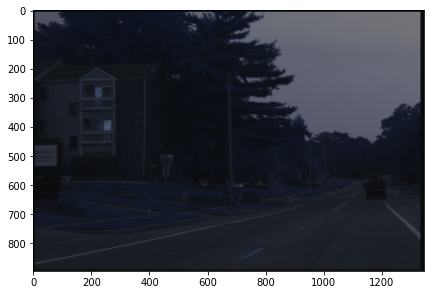

In [12]:
plt.figure(figsize = (7,7))
plt.imshow(X[i].permute([1,2,0]))



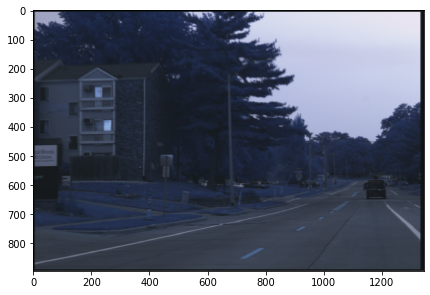

In [13]:
plt.figure(figsize = (7,7))
plt.imshow(y[i].permute([1,2,0]))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


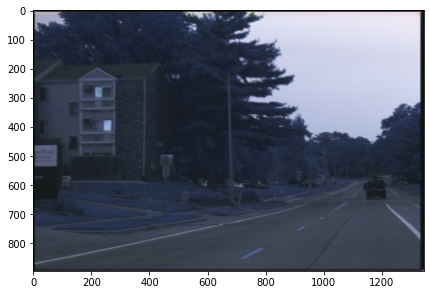

In [14]:
plt.figure(figsize = (7,7))
plt.imshow(pred[i].cpu().detach().permute([1,2,0]))



In [15]:
pred_view = pred[i].cpu().detach().permute([1,2,0])
y_view = y[i].permute([1,2,0])

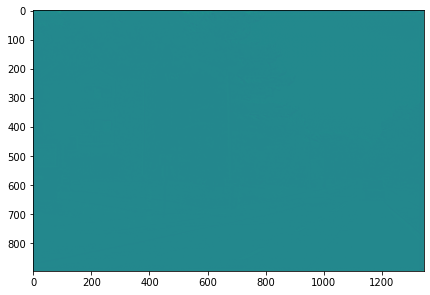

In [16]:
plt.figure(figsize = (7,7))
tmp = pred_view-y_view
tmp -= torch.min(tmp)
tmp /= torch.max(tmp)
plt.imshow(tmp[:,:,0])



In [17]:
torch.min(tmp)

tensor(0.)

In [18]:
torch.max(tmp)

tensor(1.)

In [19]:
loss  = torch.nn.MSELoss()

In [22]:
from tqdm.notebook import tqdm

In [189]:
losses = []
with torch.no_grad():
    for X, y in tqdm(testing_dataloader):

        pred = model(X.cuda())

        losses.append(loss(pred[:, :, 2:-2:2, 2:-2:2], y[:, :, 2:-2:2, 2:-2:2].cuda()))

  0%|          | 0/5588 [00:00<?, ?it/s]

In [190]:
sum([p.numel() for p in model.parameters()])

7941571

In [191]:
def bilin_interp_conv(X):
    pixels = torch.clone(X)
    #print(pixels.shape)
    if pixels[0][0][0] != 0: 
        pixels = pixels[:, 1:, :]
    weights = torch.tensor([[0., 1/4., 0.],
                            [1/4., 0., 1/4.],
                            [0., 1/4., 0.]])
    weights = weights.view(1, 3, 3).repeat(1, 1, 1).cuda()
    out_channels = torch.Tensor().cuda()
    for channel in pixels:
       # print(weights.shape)
        output_channel = F.conv2d(channel.unsqueeze(0).unsqueeze(0), weights.unsqueeze(0), stride=2, padding=1)
        out_channels = torch.cat((output_channel, out_channels), 0)
    return out_channels

In [239]:
def conv_y(y, zero_start, pred_shape):
    print(y.shape)
    print(pred.shape)

    tmp = torch.zeros(pred_shape)

    for chan, channel in enumerate(y[0]):
        for r, row in enumerate(channel):
            for c, pos in enumerate(row):
                if (r+c)%2 == zero_start: 
                    tmp[chan][r//2][c//2] =  y[0][chan][r][c]
    return tmp


In [248]:
losses_bilinear = []
with torch.no_grad():
    for X, y in tqdm(testing_dataloader):

        pred = bilin_interp_conv(X[0].cuda())
        pred = pred.squeeze(1)
        pred = pred[:, 1:-1, 1:-1]

        losses_bilinear.append(loss(pred, y[:, :, 2:-2:2, 2:-2:2].cuda()))

  0%|          | 0/5588 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 3, 446, 670])) that is different to the input size (torch.Size([3, 446, 670])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
# losses_bilinear = []
# with torch.no_grad():
#     for X, y in tqdm(testing_dataloader):

#         pred = bilin_interp_conv(X[0].cuda())
#         pred = pred.squeeze(1)
        
#         o = 0
#         if X[0][0][0][0] == 0:
#             o += 1
#         y = conv_y(y, bool(o), pred.shape)
#         pred = pred[:, 1:-1, 1:-1]
#         y = y[:, 1:-1, 1:-1]
#         losses_bilinear.append(loss(pred, y.cuda()))

In [241]:
losses_bilinear

[tensor(0.0182, device='cuda:0'),
 tensor(0.0184, device='cuda:0'),
 tensor(0.0196, device='cuda:0'),
 tensor(0.0203, device='cuda:0'),
 tensor(0.0204, device='cuda:0')]

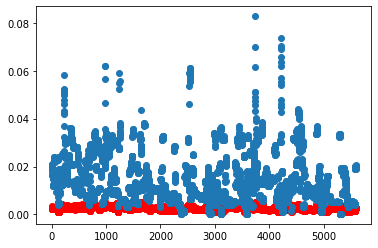

In [253]:
plt.figure()
plt.scatter(range(len(a)), a, c='r')
plt.scatter(range(len(b)), b)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   5.,   5.,   1.,   3.,   2.,   1.,   1.,   3.,
          1.,   2.,   4.,   0.,   3.,   2.,   0.,   1.,   1.,   1.,   2.,
          3.,   1.,   1.,   5.,   7.,   6.,   1.,   2.,   1.,   1.,  12.,
         13.,  24.,  25.,  28.,  48.,  84.,  80., 137.,  77.,  37.,  41.,
         50.,  47.,  39.,  48.,  78.,  68.,  37.,  51.,  75.,  65., 110.,
        114., 155., 114., 161., 148., 148., 181., 189., 168., 254., 252.,
        288., 307., 244., 222., 243., 422., 184., 190.,  95.,  86.,  73.,
          3.]),
 array([-0.07768333, -0.07688397, -0.0760846 , -0.07528524, -0.07448587,
        -0.0736865 , -0.07288714, -0.07208777, -0.07128841, -0.07048904,
        -0.06968968, -0.06889031, -0.06809095, -0.06729158, -0.06649222,
        -0.06569285, -0.06489349, -0.06409412, -0.06329476, -0.06249539,
        -0.06169602, -0.06

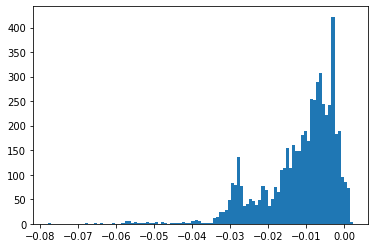

In [254]:
plt.hist([a[i]-b[i] for i in range(len(b))], bins=100)

In [222]:
torch.mean(torch.Tensor(losses))

tensor(0.0013)

In [223]:
torch.mean(torch.Tensor(losses_bilinear))

tensor(0.0141)

In [186]:
y[:, :, ::2, ::2].shape


torch.Size([1, 3, 448, 672])

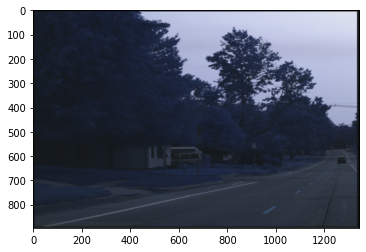

In [178]:
plt.imshow(y.squeeze().cpu().detach().permute([1,2,0]))

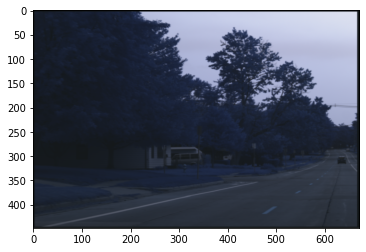

In [182]:
plt.imshow(pred.cpu().detach().permute([1,2,0])[:, :, [2,1,0]])

In [180]:
pred.shape

torch.Size([3, 448, 672])

In [56]:
import torch.nn.functional as F

In [101]:
output

tensor([[[[1.5000, 2.2500, 2.2500, 2.2500],
          [2.2500, 3.0000, 3.0000, 3.0000],
          [2.2500, 3.0000, 3.0000, 3.0000],
          [2.2500, 3.0000, 3.0000, 3.0000]]]])

In [102]:
x.shape

torch.Size([1, 3, 8, 8])

In [103]:
x[0]

tensor([[[0., 1., 0., 1., 0., 1., 0., 1.],
         [1., 0., 1., 0., 1., 0., 1., 0.],
         [0., 1., 0., 1., 0., 1., 0., 1.],
         [1., 0., 1., 0., 1., 0., 1., 0.],
         [0., 1., 0., 1., 0., 1., 0., 1.],
         [1., 0., 1., 0., 1., 0., 1., 0.],
         [0., 1., 0., 1., 0., 1., 0., 1.],
         [1., 0., 1., 0., 1., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0., 1.],
         [1., 0., 1., 0., 1., 0., 1., 0.],
         [0., 1., 0., 1., 0., 1., 0., 1.],
         [1., 0., 1., 0., 1., 0., 1., 0.],
         [0., 1., 0., 1., 0., 1., 0., 1.],
         [1., 0., 1., 0., 1., 0., 1., 0.],
         [0., 1., 0., 1., 0., 1., 0., 1.],
         [1., 0., 1., 0., 1., 0., 1., 0.]],

        [[0., 1., 0., 1., 0., 1., 0., 1.],
         [1., 0., 1., 0., 1., 0., 1., 0.],
         [0., 1., 0., 1., 0., 1., 0., 1.],
         [1., 0., 1., 0., 1., 0., 1., 0.],
         [0., 1., 0., 1., 0., 1., 0., 1.],
         [1., 0., 1., 0., 1., 0., 1., 0.],
         [0., 1., 0., 1., 0., 1., 0., 1.],
       